# Looking at and random sampling from the 2D-encoded latent space.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import markers
from random import uniform, choice
import absl.logging
import os
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from keras import models

In [2]:
ptarr = np.load("saves/2d_points.npy", allow_pickle=True)

### Representations during training for each digit.
This is a lot cooler when the plots are interactive and not frozen to a png.

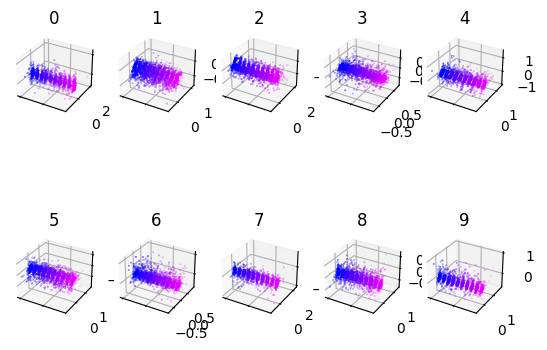

In [3]:
_, ax0 = plt.subplots(2, 5, subplot_kw={"projection": "3d"})

a, b = 10, len(ptarr)
for epoch in range(a, b):
    for dig in range(10):
        i, j = (dig - dig % 5) // 5, dig % 5
        x = ([epoch for _ in range(len(ptarr[epoch][dig][0]))])
        y = (ptarr[epoch][dig][0])
        z = (ptarr[epoch][dig][1])

        ax0[i, j].set_xticklabels([])
        ax0[i, j].title.set_text(f"{dig}")
        ax0[i, j].scatter3D(x, y, z, s=0.05, color=[(epoch - a) / (b - a), 0, 1])
plt.show()

### Final mapping regions for each digit
Here too 0's region is quite far off from the rest while luckily 1 is well-behaved, albeit again in a much smaller region given its ease of representation.

In [4]:
encoder2d = models.load_model("saved_models/encoder_2d", compile=False)

train_df = pd.read_csv("mnist/mnist_train.csv", header=None)
train_x = np.array(train_df.iloc[:, 1:].to_numpy().reshape((-1, 28, 28, 1)))
train_x = train_x/255.
train_y = np.array(train_df.iloc[:, 0].to_numpy().reshape((-1, 1)))


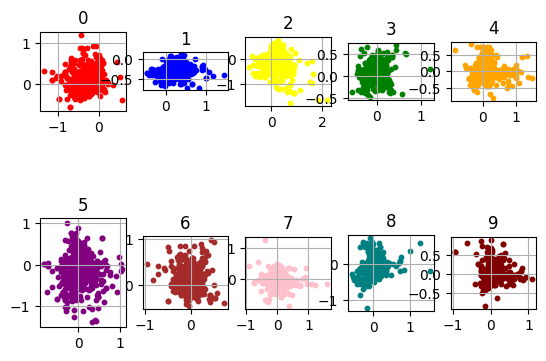

In [8]:
_, ax1 = plt.subplots(2, 5)

colors = ["red", "blue", "yellow", "green", "orange", "purple", "brown", "pink", "teal", "maroon"]
preds = {}
for dig in range(10):
    i, j = (dig - dig % 5) // 5, dig % 5
    dig_samp_xs, dig_samp_ys = [], []
    for _ in range(1000):
        ind = choice(range(len(train_x)))
        while train_y[ind].item() != dig:
            ind = choice(range(len(train_x)))

        dig_samp_xs.append(train_x[ind])
        dig_samp_ys.append(train_y[ind])

    dig_samp_xs = np.array(dig_samp_xs).reshape((-1, 28, 28, 1))
    dig_pred_ys = encoder2d.predict(dig_samp_xs, verbose=0)
    preds[dig] = dig_pred_ys
    ax1[i, j].set_aspect("equal", "box")
    ax1[i, j].title.set_text(f"{dig}")
    ax1[i, j].scatter(dig_pred_ys[:, 0], dig_pred_ys[:, 1], color=colors[dig], s=10)
    ax1[i, j].grid(True)
plt.show()

### All final mappings on the same plot to get a sense of differentiation in class representations.
In 2d there is already quite some movement from "densely populating a small region near the origin". This becomes far more apparent in higher dimensions.

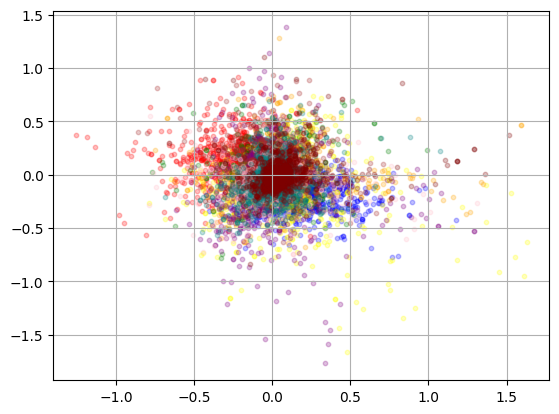

In [6]:
for dig in range(10):
    plt.scatter(preds[dig][:, 0], preds[dig][:, 1], color=[colors[dig]], alpha=0.25, s=10)

plt.grid(True)
plt.show()

### Random sampling by class
A lot more variation/novelty can clearly be seen here although the 1s suffer from being sampled from points not well within their comfy little region.

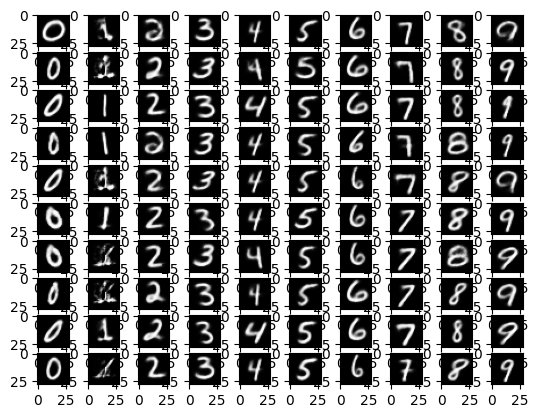

In [7]:
decoder2d = models.load_model("saved_models/decoder_2d", compile=False)
r = 0.3

_, ax2 = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        hotcode = [0] * 10
        hotcode[j] = 1
        sample = np.array([[uniform(-r, r), uniform(-r, r), *hotcode]])
        pred = decoder2d.predict(sample, verbose=0)[0]
        ax2[i, j].imshow(pred, cmap="gray")
plt.show()
